This notebook runs a `Qallse` model in simulation mode and shows how to simply visualize the results using utilities defined in module `hepqpr.qallse.plotting`.

# Import and setup

In [1]:
# import modules
import pandas as pd
import numpy as np

from hepqpr.qallse.plotting import *
from hepqpr.qallse import *

# initialise the plotting module in "notebook" mode
set_notebook_mode()

# initialise the logging module
import logging
logging.basicConfig(level=logging.INFO)
logging.getLogger('hepqpr').setLevel(logging.DEBUG)

# Define run config

In [2]:
# == INPUT CONFIG

# path to the input dataset
path = '~/hepqpr-publione/data/barrel_400/event000001000' 
# whether or not to add missing doublets to the input
add_missing = True 

# == RUN CONFIG

model_class = Qallse # model class to use
extra_config = dict() # configuration arguments overriding the defaults

# Execute the model

## Load the data

In [3]:
# load data
dw = DataWrapper.from_path(path)
doublets = pd.read_csv(path + '-doublets.csv')
if add_missing:
    doublets = dw.add_missing_doublets(doublets)
else:
    p, r, ms = dw.compute_score(doublets)
    print(f'got {len(doublets)}.')
    print(f'  Input precision (%): {p*100:.4f}, recall (%): {r*100:.4f}, missing: {len(ms)}')

got 76123 doublets.
  Input precision (%): 2.9649, recall (%): 84.1223
    New precision (%): 3.5049


## Build the model

In [4]:
%%time

# instantiate qallse
model = model_class(dw, **extra_config)
# build the qubo
model.build_model(doublets=doublets)
Q = model.to_qubo()

DEBUG:hepqpr.qallse.qallse:using config:
DEBUG:hepqpr.qallse.qallse:    cheat: False
DEBUG:hepqpr.qallse.qallse:    max_layer_span: 2
DEBUG:hepqpr.qallse.qallse:    num_multiplier: -1
DEBUG:hepqpr.qallse.qallse:    qplet_max_dcurv: 0.0005
DEBUG:hepqpr.qallse.qallse:    qplet_max_strength: -0.2
DEBUG:hepqpr.qallse.qallse:    qubo_bias_weight: -0.01
DEBUG:hepqpr.qallse.qallse:    qubo_conflict_strength: 0.5
DEBUG:hepqpr.qallse.qallse:    rz_power: 1
DEBUG:hepqpr.qallse.qallse:    strength_bounds: None
DEBUG:hepqpr.qallse.qallse:    tplet_max_curv: 0.005
DEBUG:hepqpr.qallse.qallse:    tplet_max_drz: 0.2
DEBUG:hepqpr.qallse.qallse:    volayer_power: 2
DEBUG:hepqpr.qallse.qallse:    xy_power: 1
DEBUG:hepqpr.qallse.qallse:    xy_relative_strength: 0.5
INFO:hepqpr.qallse.qallse:created 42866 doublets.
INFO:hepqpr.qallse.qallse:created 90167 triplets.
INFO:hepqpr.qallse.qallse:created 7416 quadruplets.
INFO:hepqpr.qallse.qallse:Model built in 11.88s. doublets: 7742, triplets: 8482, quadruplets

CPU times: user 12.8 s, sys: 189 ms, total: 13 s
Wall time: 13 s


## Sample the QUBO

Here, we use [_qbsolv_](https://github.com/dwavesystems/qbsolv) with default arguments. This means only classical algorithms.

In [5]:
%%time
# execute the qubo
response = model.sample_qubo(Q=Q)

INFO:hepqpr.qallse.qallse:QUBO of size 119852 sampled in 238.76s.


CPU times: user 3min 58s, sys: 1.41 s, total: 3min 59s
Wall time: 3min 58s


## Parse the results

In [6]:
# get all output doublets
all_doublets = model.process_sample(next(response.samples()))
# recreate tracks and resolve remaining conflicts
final_tracks, final_doublets = TrackRecreaterD().process_results(all_doublets)

INFO:hepqpr.qallse.track_recreater:Found 6 conflicting segments
DEBUG:hepqpr.qallse.track_recreater:Conflicts added: [20091, 28833], [84465, 91417], [18730, 27379].
INFO:hepqpr.qallse.track_recreater:Added 3 conflicting segments


# Evaluate the results

## Print statistics and scores

In [7]:
# stats about the qbsolv run
en0 = dw.compute_energy(Q)
en = response.record.energy[0]
print(f'SAMPLE -- energy: {en:.4f}, ideal: {en0:.4f} (diff: {en-en0:.6f})')
occs = response.record.num_occurrences
print(f'          best sample occurrence: {occs[0]}/{occs.sum()}')

# scores
p, r, missings = dw.compute_score(final_doublets)
print(f'SCORE  -- precision (%): {p * 100}, recall (%): {r * 100}, missing: {len(missings)}')
trackml_score = dw.compute_trackml_score(final_tracks)
print(f'          tracks found: {len(final_tracks)}, trackml score (%): {trackml_score * 100}')

SAMPLE -- energy: -1657.9048, ideal: -1655.1984 (diff: -2.706318)
          best sample occurrence: 1/20
SCORE  -- precision (%): 99.58333333333333, recall (%): 97.98732761833769, missing: 54
          tracks found: 396, trackml score (%): 97.95571490697579


### Plot the results

You have the following at your disposal:
```python
iplot_results(dw, final_doublets, missings, dims=list('xy'))
iplot_results_tracks(dw, final_doublets, missings, dims=list('zr'))
iplot_results_any(dw, dw.real_doublets, dims=list('xy'))
```

For 3D plots, simply define `dims` as 3-dimensional. For example:
```python
iplot_results(dw, final_doublets, missings, dims=list('zxy'))
```

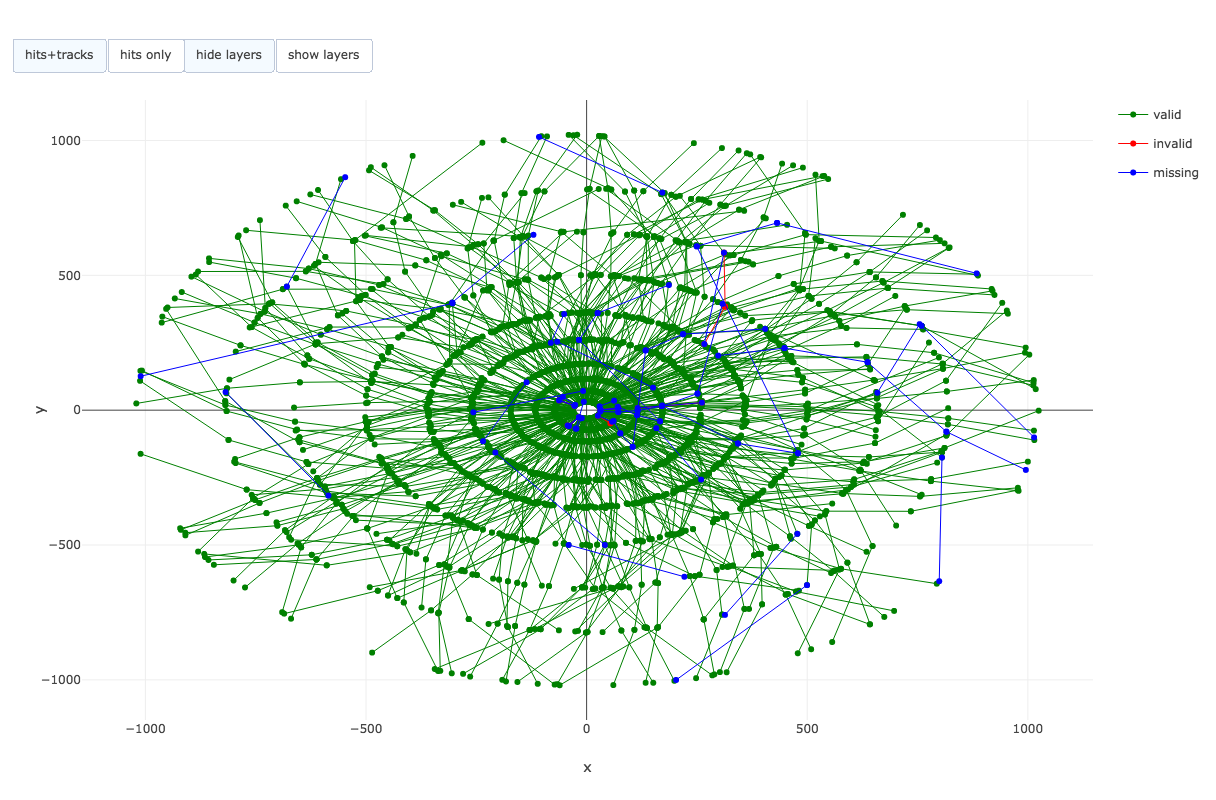

In [8]:
iplot_results(dw, final_doublets, missings, dims=list('xy'))

In [9]:
#iplot_results(dw, final_doublets, missings, dims=list('zr'))

In [10]:
#iplot_results_tracks(dw, final_tracks, dims=list('zxy'))

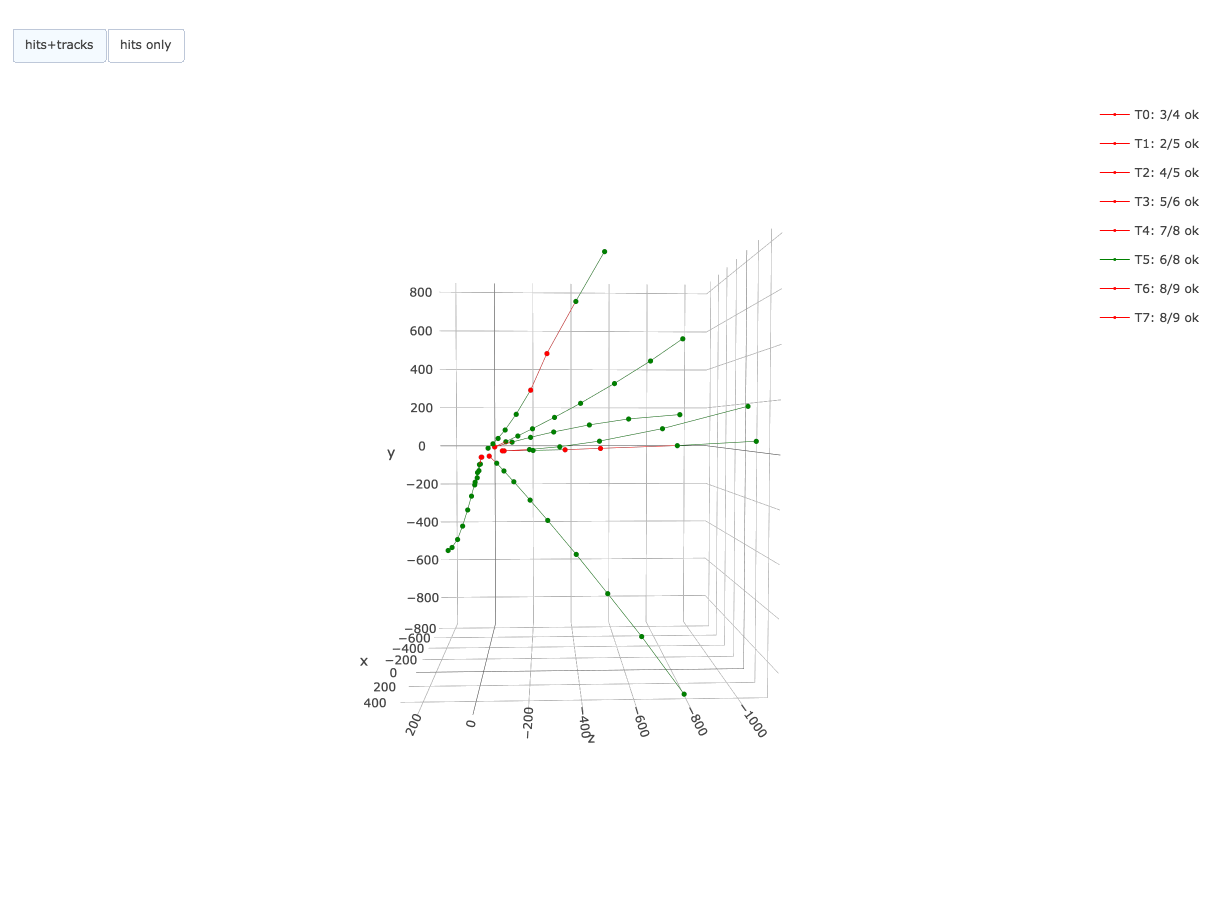

In [12]:
invalid_tracks = [t for t in final_tracks if not dw.is_real_xplet(t)]
iplot_results_tracks(dw, invalid_tracks, dims=list('zxy'))